<a href="https://colab.research.google.com/github/aayushh04/dlt/blob/main/week_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170M/170M [00:03<00:00, 46.2MB/s]


Epoch [1/25]  Loss_D: 0.7968  Loss_G: 2.7514


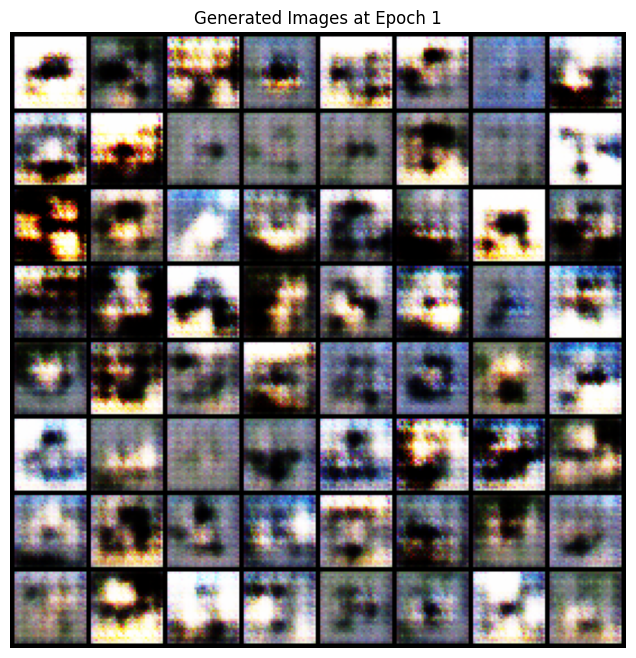

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# -------------------------
# 1. Device and Parameters
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100   # Noise vector size
image_size = 32    # CIFAR10 image size
channels = 3       # RGB
batch_size = 128
num_epochs = 25
lr = 0.0002
beta1 = 0.5

# -------------------------
# 2. Data Loading
# -------------------------
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------------------
# 3. Define Generator
# -------------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, channels, 3, 1, 1, bias=False),
            nn.Tanh()  # Output in [-1,1]
        )

    def forward(self, x):
        return self.main(x)

# -------------------------
# 4. Define Discriminator
# -------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

# -------------------------
# 5. Initialize Models
# -------------------------
netG = Generator().to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# -------------------------
# 6. Training Loop
# -------------------------
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
G_losses, D_losses = [], []

for epoch in range(num_epochs):
    for i, (data, _) in enumerate(dataloader):
        # Train Discriminator
        netD.zero_grad()
        real = data.to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)

        output = netD(real)
        lossD_real = criterion(output, label)
        lossD_real.backward()

        # Train with fake images
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.)
        output = netD(fake.detach())
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        optimizerD.step()

        lossD = lossD_real + lossD_fake

        # Train Generator
        netG.zero_grad()
        label.fill_(1.)
        output = netD(fake)
        lossG = criterion(output, label)
        lossG.backward()
        optimizerG.step()

        # Store losses
        D_losses.append(lossD.item())
        G_losses.append(lossG.item())

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_D: {lossD:.4f}  Loss_G: {lossG:.4f}")

    # Generate sample images every few epochs
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        grid = make_grid(fake, padding=2, normalize=True)
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title(f"Generated Images at Epoch {epoch+1}")
        plt.imshow(grid.permute(1,2,0))
        plt.show()

# -------------------------
# 7. Plot Loss Graphs
# -------------------------
plt.figure(figsize=(7,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("DCGAN Training Losses")
plt.legend()
plt.grid(True)
plt.show()
